# LSTM Model for Oedometer Data Prediction
This code implements an LSTM model to predict future values based on time-series data for a geotechnical engineering problem. The goal is to predict `delta_sigma` values from the given inputs `sigma_t` (stress) and `delta_epsilon` (strain). Below are the code blocks with explanations.


---


## Importing Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import Markdown, display
import pandas as pd
import random as r
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

This section imports all the necessary libraries, including PyTorch, pandas, and matplotlib, which are used for neural network operations, data handling, and visualization.


---


## Setting Parameters

In [2]:
# Debugger: Aktiviert
debug_mode = True
normalize = False

Here, we define two key parameters:

*   `debug_mode`: Used to toggle debugging functionalities.
*   `normalize`: A flag to enable or disable data normalization.


---


## Preloaded Helper Functions

In [3]:
def dict_to_markdown_table(data: dict, title: str = "Datenübersicht", include_index: bool = True, round_digits: int = 4):
    """
    Wandelt ein Dictionary mit Listenwerten in eine Markdown-Tabelle für Jupyter Notebooks um.

    - Schlüssel werden als Header genutzt
    - Erste Spalte ist ein Index, falls `include_index=True`
    - Einzelwerte werden als separate Tabelle unterhalb dargestellt
    - Zahlenwerte werden auf eine einstellbare Anzahl an Nachkommastellen gerundet

    :param data: Dictionary mit Key-Value-Paaren
    :param title: Überschrift für die Tabelle
    :param include_index: Falls True, wird eine Index-Spalte erstellt
    :param round_digits: Anzahl der Nachkommastellen, auf die Werte gerundet werden sollen
    :return: Markdown-String zur Anzeige in Jupyter
    """

    # Hilfsfunktion zum Runden von Zahlen
    def round_value(val):
        if isinstance(val, (int, float)):
            return round(val, round_digits)
        return val

    # Listen und einzelne Werte trennen
    list_data = {k: v for k, v in data.items() if isinstance(v, list)}
    single_values = {k: v for k, v in data.items() if not isinstance(v, list)}

    # Falls es Listen gibt, erstelle eine Tabelle mit Index
    if list_data:
        max_len = max(len(v) for v in list_data.values())  # Längste Liste bestimmen

        # Tabellenkopf
        md_table = f"### {title}\n\n"
        md_table += "| " + ("Index | " if include_index else "") + " | ".join(list_data.keys()) + " |\n"
        md_table += "|-" + ("-|" if include_index else "") + "-|".join(["-" * len(k) for k in list_data.keys()]) + "-|\n"

        # Datenzeilen
        for i in range(max_len):
            row = [str(i)] if include_index else []  # Index hinzufügen (optional)
            for key in list_data:
                if i < len(list_data[key]):
                    row.append(str(round_value(list_data[key][i])))
                else:
                    row.append("")  # Leere Werte für ungleich lange Listen
            md_table += "| " + " | ".join(row) + " |\n"

    else:
        md_table = ""

    # Einzelwerte als extra Tabelle darstellen
    if single_values:
        md_table += "\n\n#### Einzelwerte\n\n"
        md_table += "| " + " | ".join(single_values.keys()) + " |\n"
        md_table += "|-" + "-|".join(["-" * len(k) for k in single_values.keys()]) + "-|\n"
        md_table += "| " + " | ".join(map(lambda v: str(round_value(v)), single_values.values())) + " |\n"

    return Markdown(md_table)


def display_data_loss_table(data_dict, delta_sigma_pred, max_i):
    """
    Erstellt eine Markdown-Tabelle zur übersichtlichen Darstellung von Datenverlust.

    Unterstützt sowohl Python-Listen als auch NumPy-Arrays.

    :param data_dict: Dictionary mit `sigma_t` und `delta_sigma` (Listen oder np.arrays)
    :param delta_sigma_pred: Vorhergesagte Werte für `delta_sigma` (Liste oder np.array)
    :param max_i: Anzahl der Werte, die in der Tabelle angezeigt werden sollen
    """

    # Sicherstellen, dass `sigma_t` und `delta_sigma` existieren
    if "sigma_t" not in data_dict or "delta_sigma" not in data_dict or delta_sigma_pred is None:
        print("Fehler: `data_dict` oder `delta_sigma_pred` ist nicht korrekt definiert!")
        return

    # Konvertiere alle Werte zu Listen (falls sie NumPy-Arrays sind)
    def to_list(arr):
        return arr.tolist() if isinstance(arr, np.ndarray) else arr

    total_epsilon = to_list(data_dict["total_epsilon"])
    delta_epsilon = to_list(data_dict["delta_epsilon"])
    sigma_t = to_list(data_dict["sigma_t"])
    delta_sigma_true = to_list(data_dict["delta_sigma"])
    delta_sigma_pred = to_list(delta_sigma_pred)  # Falls `delta_sigma_pred` ein 2D-Array ist

    # Überprüfen, ob die Längen konsistent sind
    min_len = min(len(total_epsilon), len(sigma_t), len(delta_epsilon), len(delta_sigma_true), len(delta_sigma_pred), max_i)

    # Erstelle eine Tabelle für die übersichtliche Darstellung
    data_loss_table = {
        "total_epsilon" : list(total_epsilon[:min_len]),
        "delta_epsilon" : list(delta_epsilon[:min_len]),
        "sigma_t" : list(sigma_t[:min_len]),
        "True delta_sigma": list(delta_sigma_true[:min_len]),
        "Predicted delta_sigma": list(delta_sigma_pred[:min_len]),
        "Test-Loss (True - Predicted)": list(np.round(np.array(delta_sigma_true[:min_len]) - np.array(delta_sigma_pred[:min_len]), 5))
    }

    # Markdown-Tabelle für bessere Darstellung in Jupyter
    display(dict_to_markdown_table(data_loss_table, title=f"Data-Loss bis sigma_{min_len-1}", include_index=True))

This function converts a dictionary of lists into a Markdown table for easy visualization in Jupyter Notebooks. It helps in presenting data in a clear and structured way during debugging and analysis.


---


## Check for use of CONDA if available

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

No GPU available.




---


## Defining the Oedometer Class

In [5]:
import random

class Oedometer:
    def __init__(self, e_0: float = 1.00, C_c: float = 0.005, delta_epsilon: float = 0.0005,
                 sigma_t: float = 1.00, max_n: int = 50, rand_epsilon:bool=False, **kwargs):
        self.max_n = max_n

        # Standardwerte als Listen setzen
        self.e_0 = [e_0]
        self.C_c = [C_c]
        self.sigma_t = [sigma_t]
        self.delta_epsilon = []
        self.total_epsilon = [0]

        # Initiale Listen für Berechnungen
        self.sigma_t = [sigma_t]
        self.delta_sigma = []
        self.e_s = []
        self.delta_epsilon = [delta_epsilon]

        # Dynamische Zuweisung von kwargs, falls vorhanden
        for key, value in kwargs.items():
            if hasattr(self, key):  # Nur vorhandene Attribute setzen
                setattr(self, key, [value])

        # Berechnungen durchführen
        self.__calc_sigma_t_p1()

        # Listenlängen anpassen
        self.__adjust_list_lengths()
        self.__calc_total_epsilon()

    def __adjust_list_lengths(self):
        """ Passt ALLE Listen-Attribute an `max_n` an. """
        attributes = ['e_0', 'C_c', 'delta_epsilon', 'sigma_t', 'sigma_t', 'delta_sigma', 'e_s']
        for attr in attributes:
            value_list = getattr(self, attr, [])
            current_length = len(value_list)

            if current_length > self.max_n:
                setattr(self, attr, value_list[:self.max_n])  # Kürzen
            elif current_length < self.max_n:
                setattr(self, attr, value_list + [value_list[-1] if value_list else 0] * (self.max_n - current_length))  # Auffüllen

    def __calc_total_epsilon(self):
        for i in range(len(self.delta_epsilon)-1):
            self.total_epsilon.append(self.total_epsilon[i] + self.delta_epsilon[i])

    def __calc_e_s(self, sigma_t):
        """ Berechnet `e_s` aus `sigma_t`. """
        e_s = (1 + self.e_0[0]) / self.C_c[0] * sigma_t
        self.e_s.append(e_s)
        return e_s

    def __calc_sigma_t_p1(self):
        """ Berechnet `sigma_t` und `delta_sigma` für die nächsten Schritte. """
        for i in range(self.max_n):  # -1, weil sigma_t bereits gesetzt ist
            e_s = self.__calc_e_s(self.sigma_t[i])
            delta_sigma = e_s * self.delta_epsilon[0]
            sigma = self.sigma_t[i] + delta_sigma
            self.sigma_t.append(sigma)
            self.delta_sigma.append(delta_sigma)

def plot_input():
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(data_dict_raw['sigma_t'], data_dict_raw['delta_sigma'], marker='o', linestyle='-', label='Sigma_0 = 1')

    # Formatting
    plt.xlabel('sigma_t')
    plt.ylabel('delta_simga')
    plt.title('Sigma_0 in relation to Sigma_1')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

The `Oedometer` class simulates the calculation of `delta_sigma` values based on various material parameters such as `sigma_t` (stress), `delta_epsilon` (strain), and others. The class provides methods to adjust list lengths and perform calculations that simulate geotechnical behavior.


---


## Data Generation and Processing

In [6]:
i = 100

oedo_para = {
    'max_n': 1,
    'e_0': 1.0,
    'C_c': 0.005,
    'total_epsilon': 0,
    'e_s': 400.0
}

# Vorbereitung Tensoren
sigma_t = np.random.choice(range(1, 1000), size=i, replace=False)
delta_sigma = []
delta_epsilon = np.repeat(np.array(np.float64(0.0005)), i)
# delta_epsilon = np.random.uniform(0.0001, 0.001, size=i)

for i in range(i):
    oedo_para['sigma_t'] = sigma_t[i]
    oedo_para['e_s'] = delta_epsilon[i]
    oedo = Oedometer(**oedo_para)
    delta_sigma.append(round(oedo.delta_sigma[0], 2))


print('Anzahl Elemente delta_epsilon: ' + str(len(delta_epsilon)))
print('Anzahl Elemente sigma_t: ' + str(len(sigma_t)))
print('Anzahl Elemente delta_sigma: ' + str(len(delta_sigma)))

Anzahl Elemente delta_epsilon: 100
Anzahl Elemente sigma_t: 100
Anzahl Elemente delta_sigma: 100


This part generates synthetic data for `sigma_t` (stress) and `delta_epsilon` (strain) to simulate the inputs. The class Oedometer is used to compute `delta_sigma` values from the generated data.

---


## Visualizing the Data

In [7]:
data = {
    'sigma_t' : sigma_t.tolist(),
    'e_s' : delta_sigma,
}

# data = {
# 'sigma_t' : [1,2,3,4,5],
#     'delta_sigma' : [2,3,4,5,6],
#     'delta_epsilon' : [3,5,7,9,11]
# }

df = pd.DataFrame(data)
# Markdown Headlin 'RawData'
display(Markdown('### RawData'))
display(Markdown(df.to_markdown()))

### RawData

|    |   sigma_t |   e_s |
|---:|----------:|------:|
|  0 |       664 | 132.8 |
|  1 |       486 |  97.2 |
|  2 |       201 |  40.2 |
|  3 |       871 | 174.2 |
|  4 |       811 | 162.2 |
|  5 |        71 |  14.2 |
|  6 |       476 |  95.2 |
|  7 |        94 |  18.8 |
|  8 |       460 |  92   |
|  9 |        54 |  10.8 |
| 10 |       228 |  45.6 |
| 11 |       861 | 172.2 |
| 12 |       266 |  53.2 |
| 13 |       751 | 150.2 |
| 14 |       208 |  41.6 |
| 15 |       641 | 128.2 |
| 16 |       643 | 128.6 |
| 17 |       989 | 197.8 |
| 18 |       719 | 143.8 |
| 19 |       718 | 143.6 |
| 20 |       222 |  44.4 |
| 21 |       646 | 129.2 |
| 22 |       261 |  52.2 |
| 23 |       671 | 134.2 |
| 24 |       587 | 117.4 |
| 25 |       132 |  26.4 |
| 26 |       195 |  39   |
| 27 |       356 |  71.2 |
| 28 |        69 |  13.8 |
| 29 |       351 |  70.2 |
| 30 |       295 |  59   |
| 31 |       254 |  50.8 |
| 32 |       923 | 184.6 |
| 33 |       591 | 118.2 |
| 34 |       942 | 188.4 |
| 35 |       499 |  99.8 |
| 36 |       684 | 136.8 |
| 37 |       972 | 194.4 |
| 38 |       473 |  94.6 |
| 39 |       639 | 127.8 |
| 40 |       534 | 106.8 |
| 41 |       683 | 136.6 |
| 42 |       877 | 175.4 |
| 43 |       726 | 145.2 |
| 44 |       961 | 192.2 |
| 45 |       613 | 122.6 |
| 46 |       695 | 139   |
| 47 |       687 | 137.4 |
| 48 |       883 | 176.6 |
| 49 |       441 |  88.2 |
| 50 |        60 |  12   |
| 51 |       272 |  54.4 |
| 52 |       503 | 100.6 |
| 53 |        39 |   7.8 |
| 54 |       302 |  60.4 |
| 55 |       526 | 105.2 |
| 56 |       522 | 104.4 |
| 57 |       271 |  54.2 |
| 58 |       163 |  32.6 |
| 59 |       600 | 120   |
| 60 |       822 | 164.4 |
| 61 |       798 | 159.6 |
| 62 |        48 |   9.6 |
| 63 |       186 |  37.2 |
| 64 |       994 | 198.8 |
| 65 |       197 |  39.4 |
| 66 |       471 |  94.2 |
| 67 |       860 | 172   |
| 68 |       256 |  51.2 |
| 69 |       621 | 124.2 |
| 70 |       436 |  87.2 |
| 71 |       575 | 115   |
| 72 |       138 |  27.6 |
| 73 |       967 | 193.4 |
| 74 |       849 | 169.8 |
| 75 |        53 |  10.6 |
| 76 |       757 | 151.4 |
| 77 |       996 | 199.2 |
| 78 |       854 | 170.8 |
| 79 |       949 | 189.8 |
| 80 |        26 |   5.2 |
| 81 |       650 | 130   |
| 82 |       358 |  71.6 |
| 83 |       953 | 190.6 |
| 84 |       632 | 126.4 |
| 85 |       593 | 118.6 |
| 86 |       383 |  76.6 |
| 87 |       470 |  94   |
| 88 |       334 |  66.8 |
| 89 |       817 | 163.4 |
| 90 |       644 | 128.8 |
| 91 |       903 | 180.6 |
| 92 |       615 | 123   |
| 93 |       930 | 186   |
| 94 |       640 | 128   |
| 95 |       866 | 173.2 |
| 96 |       395 |  79   |
| 97 |       813 | 162.6 |
| 98 |       884 | 176.8 |
| 99 |       202 |  40.4 |

Here, the raw data is converted into a pandas DataFrame and displayed as a Markdown table. This allows for easy inspection of the data before feeding it into the LSTM model.


---


## Data Normalization

In [8]:
min_val_in = None
max_val_in = None
min_val_out = None
max_val_out = None

def min_max_normalize(tensor, input_tensor=True):
    """
      Normalisiert einen Tensor anhand der globalen min_val und max_val.
      """
    global min_val_in, max_val_in, min_val_out, max_val_out
    if min_val_in is None and max_val_in is None and input_tensor:
        min_val = torch.min(tensor)
        max_val = torch.max(tensor)
        min_val_in = min_val
        max_val_in = max_val
        print(min_val)
        print(max_val)
    elif min_val_out is None and max_val_out is None and not input_tensor:
        min_val = torch.min(tensor)
        max_val = torch.max(tensor)
        min_val_out = min_val
        max_val_out = max_val
    elif input_tensor:
        min_val = min_val_in
        max_val = min_val_in
    elif not input_tensor:
        min_val = min_val_out
        max_val = min_val_out
              
        
    display(Markdown(f'### Skalierungseinheiten für {'Input' if input_tensor else 'Output'}: Min. = {min_val}, Max. = {max_val}'))
    return (tensor - min_val) / (max_val - min_val)

def min_max_denormalize(tensor, input_tensor=True):
    """
      Denormalisiert einen Tensor anhand der globalen min_val und max_val.
      """
    if min_val_in is None and max_val_in is None and input_tensor:
        print("Fehler: min_val und/oder max_val sind nicht gesetzt. Normalisierung muss zuerst durchgeführt werden.")
        return tensor # Gibt den ursprünglichen Tensor zurück, wenn nicht normalisiert werden kann
    elif min_val_out is None and max_val_out is None and not input_tensor:
        print("Fehler: min_val und/oder max_val sind nicht gesetzt. Normalisierung muss zuerst durchgeführt werden.")
        return tensor # Gibt den ursprünglichen Tensor zurück, wenn nicht normalisiert werden kann
    if input_tensor:
        min_val = min_val_in
        max_val = max_val_in
    else:
        min_val = min_val_out
        max_val = max_val_out
    return tensor * (max_val - min_val) + min_val


This function normalizes input tensors using the Min-Max scaling method. Normalization helps in improving the training stability by ensuring that all features are within the same scale.


---

## Creating the Dataset for LSTM



In [9]:
def create_dataset(df, lookback=1, input_columns=None, output_columns=None, normalize=True):
    """
    Erzeugt die Eingabe- und Ziel-Datensätze für ein LSTM.

    Parameters:
    df (DataFrame): Der Eingabedatenrahmen.
    lookback (int): Die Anzahl der vergangenen Zeitschritte, die als Eingabe dienen.
    input_columns (list): Liste der Spaltennamen, die als Eingabewerte dienen.
    output_columns (list): Liste der Spaltennamen, die als Zielwerte dienen.
    normalize (bool): Ob die Eingabedaten normalisiert werden sollen.

    Returns:
    X (Tensor): Eingabedaten im Format (batch_size, seq_length, input_size).
    y (Tensor): Zielwerte im Format (batch_size, output_size).
    """
    X, y = [], []

    # Falls keine input_columns übergeben wurden, nehmen wir alle Spalten außer der letzten
    if input_columns is None:
        input_columns = df.columns[:-1].tolist()

    # Falls keine output_columns übergeben wurden, nehmen wir die letzte(n) Spalte(n)
    if output_columns is None:
        output_columns = df.columns[-1:].tolist()  # Eine Liste mit der letzten Spalte

    for i in range(len(df) - lookback):
        # Wir nehmen 'lookback' Zeilen als eine Sequenz für die Eingabe
        seq = df.iloc[i:i+lookback][input_columns].values
        X.append(seq)

        # Zielwert(e) ist (sind) der Wert(e) der output_columns nach dieser Sequenz
        y_values = df.iloc[i+lookback][output_columns].values
        y.append(y_values)

    # Umwandlung in Tensoren
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32)

    # Falls Normalisierung gewünscht ist, wenden wir min-max Normalisierung an
    if normalize:
        X = min_max_normalize(X_tensor)
        y = min_max_normalize(y_tensor, False)
    else:
        X = X_tensor
        y = y_tensor
    return X, y

X, y = create_dataset(df, lookback=1, normalize=normalize, input_columns=['sigma_t'], output_columns=['e_s'])

This function creates the input-output pairs for the LSTM model. The `lookback` parameter determines how many previous time steps are used to predict the next value. The function normalizes the input data if the `normalize` flag is set to `True`.

In [10]:
# --- Aufteilen in Training (2/3) und Test (1/3) ---
train_size = int(X.shape[0] * 2/3)
X_train = X[:train_size]
y_train = y[:train_size].view(-1, 1)  # als (batch_size, 1)
X_test  = X[train_size:]
y_test  = y[train_size:].view(-1, 1)

print("Shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_test: ", X_test.shape,  "y_test: ", y_test.shape)

Shapes:
  X_train: torch.Size([66, 1, 1]) y_train: torch.Size([66, 1])
  X_test:  torch.Size([33, 1, 1]) y_test:  torch.Size([33, 1])


In [11]:
num_rows = 10  # Anzahl der Zeilen, die in den Tabellen angezeigt werden sollen
lookback = 1 # Stelle sicher, dass dies deinem tatsächlichen lookback-Wert entspricht

# Trainingsdaten anzeigen (Normalisiert) - Hier passen Input und Output zusammen, wie vom create_dataset erstellt
display(dict_to_markdown_table({
    'Input (sigma_t)': [X_train[i].squeeze().tolist() for i in range(min(num_rows, X_train.shape[0]))],
    'Output (e_s)': y_train[:min(num_rows, y_train.shape[0])].squeeze().tolist()
}, title="Trainingsdaten (Normalisierte Input Parameter)", include_index=True))

# Trainingsdaten denormalisiert anzeigen
X_train_denormalized = min_max_denormalize(X_train)
y_train_denormalized = min_max_denormalize(y_train, False)

# Rohdaten für den Vergleich extrahieren (entspricht den Trainingsdaten)
# Die Trainingsdaten sind die ersten 'train_size' Samples der Input-Output-Paare.
# Wir müssen die entsprechenden originalen Werte aus dem 'data' Dictionary holen.

# Die Inputs X_train[i] stammen aus den Originaldaten bei Index i.
original_sigma_t_input = data['sigma_t'][:train_size]
original_delta_epsilon_input = data['delta_epsilon'][:train_size]

# Die Outputs y_train[i] stammen aus den Originaldaten bei Index i + lookback.
original_delta_sigma_output = data['delta_sigma'][lookback : train_size + lookback]


# Listen für die detaillierte denormalisierte Tabelle
denormalized_inputs_list = []
denormalized_outputs_list = []
input_original_indices = [] # Um die Rohdaten-Indizes für Inputs zu speichern
output_original_indices = [] # Um die Rohdaten-Indizes für Outputs zu speichern
input_verification_diff = []
output_verification_diff = []

for i in range(min(num_rows, X_train_denormalized.shape[0])):
    # Denormalisierte Werte
    denorm_sigma_t = X_train_denormalized[i].squeeze()[0].item()
    denorm_delta_epsilon = X_train_denormalized[i].squeeze()[1].item()
    denorm_delta_sigma_output = y_train_denormalized[i].squeeze().item()

    denormalized_inputs_list.append([denorm_sigma_t, denorm_delta_epsilon])
    denormalized_outputs_list.append(denorm_delta_sigma_output)

    # Rohdaten-Index für den Input: i
    input_index = i
    input_original_indices.append(input_index)
    original_sigma_t = data['sigma_t'][input_index]
    original_delta_epsilon = data['delta_epsilon'][input_index]
    diff_sigma_t = denorm_sigma_t - original_sigma_t
    diff_delta_epsilon = denorm_delta_epsilon - original_delta_epsilon
    input_verification_diff.append(f"sigma_t Diff: {diff_sigma_t:.4f}, delta_epsilon Diff: {diff_delta_epsilon:.6f}")


    # Rohdaten-Index für den Output: i + lookback
    output_index = i + lookback
    output_original_indices.append(output_index)
    original_delta_sigma = data['delta_sigma'][output_index]
    diff_delta_sigma = denorm_delta_sigma_output - original_delta_sigma
    output_verification_diff.append(f"delta_sigma Diff: {diff_delta_sigma:.4f}")


display(Markdown('## Hier wird geprüft, ob das normalisieren bzw. denormalisieren funktioniert hat.'))

# Anzeige der denormalisierten Trainingsdaten mit Input-Verifizierung
# Wir fügen die Rohdaten-Indizes für Input und Output zur besseren Übersicht hinzu.
display(dict_to_markdown_table({
    'Input Rohdaten Index': input_original_indices,
    'Input (sigma_t, delta_epsilon)': denormalized_inputs_list,
    'Denormalisierung Input Check (Diff zu Original)': input_verification_diff,
    'Output Rohdaten Index': output_original_indices,
    }, title="Trainingsdaten (Denormalisiert) mit Checks", include_index=True))

### Trainingsdaten (Normalisierte Input Parameter)

| Index | Input (sigma_t) | Output (e_s) |
|--|----------------|-------------|
| 0 | 664.0 | 97.2 |
| 1 | 486.0 | 40.2 |
| 2 | 201.0 | 174.2 |
| 3 | 871.0 | 162.2 |
| 4 | 811.0 | 14.2 |
| 5 | 71.0 | 95.2 |
| 6 | 476.0 | 18.8 |
| 7 | 94.0 | 92.0 |
| 8 | 460.0 | 10.8 |
| 9 | 54.0 | 45.6 |


Fehler: min_val und/oder max_val sind nicht gesetzt. Normalisierung muss zuerst durchgeführt werden.
Fehler: min_val und/oder max_val sind nicht gesetzt. Normalisierung muss zuerst durchgeführt werden.


KeyError: 'delta_epsilon'

---


## LSTM Model Definition

In [12]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

This is the definition of the LSTM model. It uses one LSTM layer followed by a fully connected layer. The model learns from the input sequence and makes a prediction about the output value.



In [13]:
# Hyperparameter
input_size = X_train.shape[2]  # Anzahl der Input-Features
hidden_size = 32  # Die Anzahl der Neuronen im LSTM
num_layers = 10  # Anzahl der LSTM-Schichten
output_size = 1  # Output ist eine einzelne Zahl (z. B. Vorhersage)

# Modell, Loss und Optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = torch.nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)



---


## Model Training with Early Stopping

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Frühzeitige Beendigung: Überwache den Verlust auf den Validierungsdaten
best_val_loss = float('inf')  # Initialer hoher Verlust
patience = 100  # Anzahl der Epochen ohne Verbesserung, bevor das Training gestoppt wird
patience_counter = 10  # Zähler für die Anzahl der Epochen ohne Verbesserung

# Liste zum Speichern der Loss-Werte
losses = []

# Batches erstellen
batch_size = 1

# Erstelle TensorDataset und DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_test, y_test)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Improvement Block Aktivierung (True/False)
improvement_block = False

# Training
epochs = 1000
for epoch in range(epochs):
    model.train()  # Setze das Modell in den Trainingsmodus
    running_loss = 0.0

    # Schleife über Batches
    for i, (x_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Modellvorhersage
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)  # Verlust auf den Trainingsdaten
        loss.backward()
        optimizer.step()

        # Verlust sammeln
        running_loss += loss.item()

    # Durchschnittlichen Trainingsverlust berechnen
    avg_train_loss = running_loss / len(train_dataloader)
    losses.append(avg_train_loss)

    # Frühzeitige Beendigung (improvement block) aktivieren
    if improvement_block:
        # Validierungsverlust berechnen
        model.eval()  # Modell in den Evaluierungsmodus setzen
        val_loss = 0.0
        with torch.no_grad():
            for x_batch_val, y_batch_val in val_dataloader:
                val_outputs = model(x_batch_val)
                loss = criterion(val_outputs, y_batch_val)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)

        # Frühzeitige Beendigung überwachen
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # Reset der Geduld
        else:
            patience_counter += 1

        # Wenn keine Verbesserung erfolgt, abbrechen
        if patience_counter >= patience:
            print(f"Frühzeitige Beendigung nach {epoch + 1} Epochen wegen fehlender Verbesserung.")
            break

        # Ausgabe der Verlustinformationen
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
    else:
        # Ausgabe der Verlustinformationen ohne Validierung
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Value Loss: {running_loss:.6f}')

Epoch 10/1000, Train Loss: 12777.865530, Value Loss: 843339.124987
Epoch 20/1000, Train Loss: 12223.459895, Value Loss: 806748.353050
Epoch 30/1000, Train Loss: 11879.480138, Value Loss: 784045.689123
Epoch 40/1000, Train Loss: 11585.961951, Value Loss: 764673.488794
Epoch 50/1000, Train Loss: 11314.179797, Value Loss: 746735.866588
Epoch 60/1000, Train Loss: 11055.343249, Value Loss: 729652.654457
Epoch 70/1000, Train Loss: 10805.783687, Value Loss: 713181.723325



KeyboardInterrupt



This section implements the training loop with early stopping. Early stopping monitors the validation loss and stops the training process if the loss does not improve after a set number of epochs (`patience`).


---

## Loss Plotting

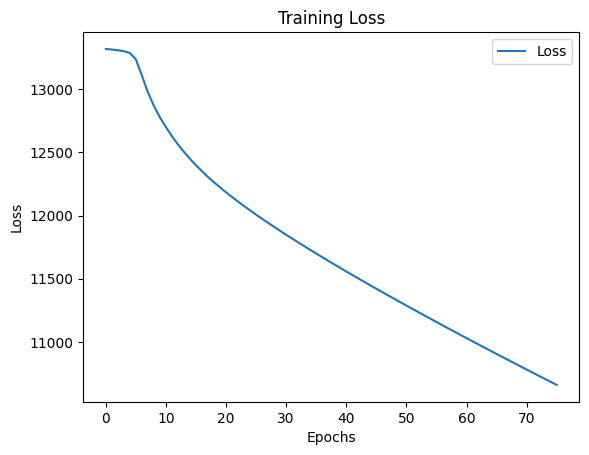

In [15]:
import matplotlib.pyplot as plt
# Plot der Losskurve
plt.plot(range(len(losses)), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

This code generates a plot of the training loss over epochs. Visualizing the loss curve is important for diagnosing model convergence and training performance.


---

## Residual and Prediction Plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_residuals(y_true, y_pred, max_points=None):
    """
    Plots the residuals (y_pred - y_true) for each sample.
    If max_points is set, only the first max_points residuals are shown.
    Converts lists to numpy arrays for subtraction.
    """
    # Ensure numpy arrays
    y_true_arr = np.array(y_true, dtype=float)
    y_pred_arr = np.array(y_pred, dtype=float)
    residuals = y_pred_arr - y_true_arr

    if max_points is not None:
        residuals = residuals[:max_points]
    plt.figure()
    plt.scatter(range(len(residuals)), residuals)
    plt.xlabel('Sample Index')
    plt.ylabel('Residual (Prediction - Real)')
    plt.title('Residual Plot')
    plt.show()

def plot_pred_vs_real(y_true, y_pred, max_points=None):
    """
    Plots predicted vs. real values.
    If max_points is set, only the first max_points points are plotted.
    Converts lists to numpy arrays for plotting.
    """
    # Ensure numpy arrays
    y_true_arr = np.array(y_true, dtype=float)
    y_pred_arr = np.array(y_pred, dtype=float)

    if max_points is not None:
        y_true_arr = y_true_arr[:max_points]
        y_pred_arr = y_pred_arr[:max_points]
    plt.figure()
    plt.plot(y_true_arr, label='Real')
    plt.plot(y_pred_arr, label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Prediction vs. Real')
    plt.legend()
    plt.show()

overfitting_check = True

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    if overfitting_check:
        X = X_train
        y = y_train
    else:
        X = X_test
        y = y_test
    y_pred_unsorted = min_max_denormalize(model(X)).tolist() #[1:]
    y_true_unsorted = min_max_denormalize(y).tolist() #[:-1]

    # sorted_indices = np.argsort(y_true_unsorted)

    y_pred = y_pred_unsorted#[sorted_indices]
    y_true = y_true_unsorted#[sorted_indices]

print(y_pred_unsorted)
print('TEST')
print(min_max_denormalize(y).tolist())

This function plots the residuals (i.e., the difference between predicted and true values) to check how well the model is fitting the data. A similar function `plot_pred_vs_real` is used to visualize the predicted vs real values.


In [ ]:
plot_residuals(y_true, y_pred)

In [ ]:
plot_pred_vs_real(y_true, y_pred)

In [ ]:
data_print = {
    'sigma_t': data['sigma_t'][1+len(y_true):],
    'delta_epsilon': data['delta_epsilon'][1+len(y_true):],
    'delta_sigma': data['delta_sigma'][1+len(y_true):],
    'delta_sigma_pred': y_pred.tolist(),
    'true - pred': [data['sigma_t'][len(y_true):][i] - y_pred.tolist()[i] for i in range(len(y_true.tolist()))]
}


# Print a markdown table
display(pd.DataFrame(data_print).head(20))



---


## Final Model Evaluation and Prediction

In [ ]:
def predict_oedometer(model, sigma_t_input, delta_epsilon_input, normalize=True):
    """
    Macht eine Prognose für delta_sigma basierend auf sigma_t und delta_epsilon
    unter Berücksichtigung von Normalisierung und der benötigten Tensor-Shape.

    Args:
        model (torch.nn.Module): Das trainierte LSTM-Modell.
        sigma_t_input (float): Der Eingabewert für sigma_t.
        delta_epsilon_input (float): Der Eingabewert für delta_epsilon.
        normalize (bool): Gibt an, ob der Input normalisiert werden soll.

    Returns:
        tuple: Ein Tuple mit (denormalisierte_prognose, wahrer_delta_sigma_wert),
               wobei der wahre Wert aus der Oedometer-Klasse ermittelt wird.
    """

    input_tensor = torch.tensor([[sigma_t_input, delta_epsilon_input]], dtype=torch.float32) # Shape (1, 1, 2)

    # Optional Normalisierung anwenden
    if normalize:
        temp_tensor = torch.tensor([[sigma_t_input, delta_epsilon_input]], dtype=torch.float32).unsqueeze(0) # Shape (1, 1, 2)
        normalized_input = min_max_normalize(temp_tensor, True)
        input_tensor = normalized_input.squeeze(0) # Shape wieder (1, 1, 2)
    else:
         # Auch wenn nicht normalisiert wird, stellen wir sicher, dass die Dimensionen korrekt sind
        input_tensor = input_tensor.unsqueeze(0) # Shape (1, 1, 2)


    # Setze das Modell in den Evaluierungsmodus
    model.eval()

    # Mache die Prognose ohne Gradientenberechnung
    with torch.no_grad():
        prediction = min_max_denormalize(model(input_tensor))

    predicted_delta_sigma = prediction.item() # Konvertiere den Tensor zu einem Python-Float

    # Ermittle den wahren Wert aus der Oedometer-Klasse
    oedo_para_prediction = {
        'max_n': 1,
        'e_0': 1.0,
        'C_c': 0.005,
        'sigma_t': sigma_t_input, # Der gegebene Input sigma_t
        'delta_epsilon': delta_epsilon_input, # Der gegebene Input delta_epsilon
        'total_epsilon': 0, # Wird für die delta_sigma Berechnung im ersten Schritt nicht benötigt
        'e_s': 400.0 # Wird für die delta_sigma Berechnung im ersten Schritt nicht benötigt
    }
    oedo_prediction = Oedometer(**oedo_para_prediction)
    # Der wahre delta_sigma Wert ist der erste Wert in der delta_sigma Liste der Oedometer-Instanz
    true_delta_sigma = oedo_prediction.delta_sigma[0]


    return predicted_delta_sigma, true_delta_sigma


example_sigma_t_input = 1
example_delta_epsilon_input = 0.0005

# Mache die Prognose
predicted_delta_sigma, true_delta_sigma = predict_oedometer(
    model,
    example_sigma_t_input,
    example_delta_epsilon_input,
    normalize=normalize
)

# Berechne die Differenz
difference = predicted_delta_sigma - true_delta_sigma

# Anzeige der Ergebnisse im Markdown-Format
display(Markdown("### Prognoseergebnis"))

display(Markdown(f"""
| Parameter             | Wert (Rohdaten) |
|-----------------------|-----------------|
| Eingabe sigma_t       | {example_sigma_t_input:.4f}   |
| Eingabe delta_epsilon | {example_delta_epsilon_input:.6f}   |
| Prognostizierte delta_sigma | {predicted_delta_sigma:.4f}   |
| Wahrer delta_sigma (Oedometer) | {true_delta_sigma:.4f}   |
| Differenz (Prognose - Wahr) | {difference:.4f}   |
"""))

This final section makes a prediction using the trained LSTM model and compares the predicted value with the true value calculated using the `Oedometer` class. The results are displayed in a Markdown table for easy inspection.